### Load data

In [1]:
#imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_images(path):
    images = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path, filename))
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images

In [3]:
# load images from ./animals_train_737imgs/lie/
lie_path = './train/lie/'
run_path = './train/run/'
sit_path = './train/sit/'
walk_stand_path = './train/walk_stand/'


lie = load_images(lie_path)
run = load_images(run_path)
sit = load_images(sit_path)
walk_stand = load_images(walk_stand_path)

# plot images
fig = plt.figure(figsize=(10, 10))
for i in range(1, 4):
    fig.add_subplot(3, 3, i)
    plt.imshow(run[i-1])
    plt.axis('off')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: './animals_train_737imgs/lie/'

### Preprocessing

In [4]:
def preprocess_images(images):
    images = np.array(images)
    images = images / 255
    return images

lie = preprocess_images(lie)
run = preprocess_images(run)
sit = preprocess_images(sit)
walk_stand = preprocess_images(walk_stand)

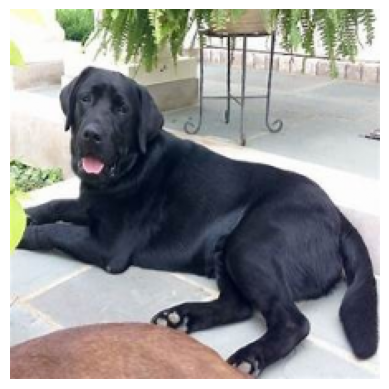

In [5]:
for i in range(1, 4):
    fig.add_subplot(3, 3, i)
    plt.imshow(lie[i-1])
    plt.axis('off')
plt.show()

In [18]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="./")

Resolving data files: 100%|██████████| 83/83 [00:00<00:00, 527465.50it/s]
Using custom data configuration default-0d3c020d50177a97
Found cached dataset imagefolder (/home/johann/.cache/huggingface/datasets/imagefolder/default-0d3c020d50177a97/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)
100%|██████████| 2/2 [00:00<00:00, 444.17it/s]


In [12]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

### Model

In [6]:
from transformers import ViTConfig, ViTModel

# Initializing a ViT vit-base-patch16-224 style configuration
configuration = ViTConfig(hidden_size = 768, num_hidden_layers = 12, num_attention_heads = 12, intermediate_size = 3072, 
                          hidden_act = 'gelu', hidden_dropout_prob = 0.0, attention_probs_dropout_prob = 0.0, 
                          initializer_range = 0.02, layer_norm_eps = 1e-12, image_size = 224, patch_size = 16,
                          num_channels = 3, qkv_bias = True, encoder_stride = 16,)  # base model configuration

# Initializing a model (with random weights) from the vit-base-patch16-224 style configuration
model = ViTModel(configuration)

# Accessing the model configuration
configuration = model.config  # add adapters?

/home/johann/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from transformers import ViTForImageClassification
from PIL import Image
import requests

ViT_ImageNet = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
# The ViT model was pretrained on ImageNet-21k, a dataset consisting of 14 million images and 21k classes, 
# and fine-tuned on ImageNet, a dataset consisting of 1 million images and 1k classes.
# print(model.config)

In [8]:
from datasets import load_dataset,Dataset,DatasetDict
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, Trainer, TrainingArguments,AutoTokenizer,AutoModel,AutoConfig
from transformers.modeling_outputs import TokenClassifierOutput
import torch
import torch.nn as nn
import pandas as pd

2024-02-09 18:28:15.484130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-09 18:28:17.098368: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/johann/anaconda3/envs/pytorch/lib/python3.9/site-packages/cv2/../../lib64:
2024-02-09 18:28:17.098535: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/johann/anaconda3/envs/pytorch/lib/python3.9

In [ ]:
class CustomModel(nn.Module):
  def __init__(self,checkpoint,num_labels): 
    super(CustomModel,self).__init__() 
    self.num_labels = num_labels 

    #Load Model with given checkpoint and extract its body
    self.model = model = AutoModel.from_pretrained(checkpoint,config=AutoConfig.from_pretrained(checkpoint, output_attentions=True,output_hidden_states=True))
    self.classifier = nn.Linear(768,num_labels) # load and initialize weights

  def forward(self, input_ids=None, attention_mask=None,labels=None):
    #Extract outputs from the body
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

    #Add custom layers
    logits = self.classifier(outputs[:,0,:].view(-1,768)) # calculate losses
    
    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    
    return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

In [ ]:
checkpoint = "google/vit-base-patch16-224"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=CustomModel(checkpoint=checkpoint,num_labels=4).to(device)

### Dataloader

In [ ]:
class PosesDataset(torch.utils.data.Dataset):
    def __init__(self, lie, run, sit, walk_stand):
        self.lie = lie
        self.run = run
        self.sit = sit
        self.walk_stand = walk_stand

        self.images = np.concatenate([lie, run, sit, walk_stand])
        self.labels = np.concatenate([np.zeros(len(lie)), np.ones(len(run)), np.ones(len(sit))*2, np.ones(len(walk_stand))*3])

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):

        images = torch.tensor(self.image[idx]).to(device)
        labels = torch.tensor(self.labels[idx]).to(device)

        return images, labels

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(PosesDataset(lie, run, sit, walk_stand), shuffle=True, batch_size=32)
# eval_dataloader = DataLoader(
#     tokenized_dataset["valid"], batch_size=32, collate_fn=data_collator
# )

### Train

In [ ]:
from transformers import AdamW,get_scheduler

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

In [ ]:
from datasets import load_metric
metric = load_metric("f1")

In [ ]:
from tqdm.auto import tqdm

progress_bar_train = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_dataloader:
        
        outputs = model(images, labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar_train.update(1)
    
    print(metric.compute())